In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [2]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis = 1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis = 1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


# 특징 만들기


In [5]:
# train['X8'] = train['X8'].str.extract(r'(PL|PS)')
# test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [6]:
# train['X8_encoded'] = (train['X8'] != 'PL').astype(int)
# test['X8_encoded'] = (test['X8'] != 'PL').astype(int)

# train = pd.get_dummies(train, columns=['X8_encoded'], prefix=['X8'])
# test = pd.get_dummies(test, columns=['X8_encoded'], prefix=['X8'])

# train[['X8_0', 'X8_1']] = train[['X8_0', 'X8_1']].astype(int)
# test[['X8_0', 'X8_1']] = test[['X8_0', 'X8_1']].astype(int)

In [7]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

In [8]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

train.drop(columns = ['X5'], inplace = True)
test.drop(columns = ['X5'], inplace = True)

In [9]:
# def estimate_rotation_speed(X2, X3, X4, X5_numeric, X6):
#     rotation_speed = X2 + (X3 / X4) * (X5_numeric / 10) * (X6 / 2)
#     return rotation_speed

# train['Estimated_Rotation_Speed'] = estimate_rotation_speed(train['X2'], train['X3'], train['X4'], train['X5_numeric'], train['X6'])
# test['Estimated_Rotation_Speed'] = estimate_rotation_speed(test['X2'], test['X3'], test['X4'], test['X5_numeric'], test['X6'])

In [10]:
train['X2/X3'] = train['X2'] / train['X3']
test['X2/X3'] = test['X2'] / test['X3']

In [11]:
train['SPT'] = train['X5_numeric'] / train['X4']
test['SPT'] = test['X5_numeric'] / test['X4']

In [12]:
train['SPTCC'] = train['SPT'] * train['X6']
test['SPTCC'] = test['SPT'] * test['X6']

In [13]:
train

,X2,X3,X4,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,X2/X3,SPT,SPTCC
0,56.3,67.5,22.5,4,97,PL973,467,2241,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069,313.6,0.834074,13.937778,55.751111
1,115.0,67.0,13.0,2,27,PL271,1058,1163,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,1.716418,24.123077,48.246154
2,59.2,44.6,18.0,1,14,PL141,270,1094,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690,313.6,1.327354,17.422222,17.422222
3,52.1,97.4,15.0,17,24,PL242,391,2604,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657,235.0,0.534908,15.666667,266.333333
4,42.9,58.7,14.5,4,23,PL233,232,1564,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.730835,16.206897,64.827586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,98.4,89.5,10.0,8,21,PS213,906,1226,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671,235.0,1.099441,23.500000,188.000000
121750,48.0,51.0,23.0,1,23,PL231,175,1540,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385,352.8,0.941176,15.339130,15.339130
121751,42.5,30.2,34.0,5,27,PL272,376,1492,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574,352.8,1.407285,10.376471,51.882353
121752,22.1,15.3,36.0,8,97,PL973,85,723,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069,352.8,1.444444,9.800000,78.400000


In [14]:
X2_idx = train[(train['X2'] > 440)].index # 440
X3_idx = train[(train['X3'] > 550)].index # 550
X4_idx = train[(train['X4'] > 36)].index
X6_idx = train[(train['X6'] > 250)].index # 250
Y1_idx = train[(train['Y1'] == 0) | (train['Y1'] > 70000)].index
Y2_idx = train[(train['Y2'] == 0) | (train['Y2'] > 70000)].index

train.loc[X2_idx, 'X2'] = train.loc[(train ['X2'] >= 500), 'X2'].mean()
train.loc[X3_idx, 'X3'] = train.loc[(train ['X3'] >= 600), 'X3'].mean()
train.loc[X4_idx, 'X4'] = train.loc[(train ['X4'] >= 36), 'X4'].mean()
train.loc[X6_idx, 'X6'] = train.loc[(train ['X6'] >= 265), 'X6'].mean()
train.loc[Y1_idx, 'Y1'] = train.loc[(train['Y1'] != 0) & (train['Y1'] <= 70000), 'Y1'].mean()
train.loc[Y2_idx, 'Y2'] = train.loc[(train['Y2'] != 0) & (train['Y2'] <= 70000), 'Y2'].mean()

In [15]:
# train['Y3'] = train['Y1'] + train['Y2']
# Q1_Y3 = train['Y3'].quantile(0.25)
# Q3_Y3 = train['Y3'].quantile(0.75)

# IQR_Y3 = Q3_Y3 - Q1_Y3

# lower_bound_Y3 = Q1_Y3 - 1.5 * IQR_Y3
# upper_bound_Y3 = Q3_Y3 + 1.5 * IQR_Y3

# train = train[(train['Y3'] >= lower_bound_Y3) & (train['Y3'] <= upper_bound_Y3)]

# train.drop(columns = 'Y3', inplace = True)
# train

In [ ]:
# mttrain = train[['X2','X3','X8','Y1']]

# mtdrop = mttrain[mttrain['Y1'] == 0].index
# mttrain.drop(mtdrop, inplace = True)

# mttest = test[['X2','X3','X8']]

In [ ]:
# scaler = MinMaxScaler()

# mtscale = mttrain.copy()
# mtscale[['X2','X3','Y1']] = scaler.fit_transform(mttrain[['X2','X3','Y1']])

In [ ]:
# X2 = mtscale[['X2','Y1']].values
# dbscan = DBSCAN(eps=0.01, min_samples=10).fit(X2)
# mtscale['clusterX2'] = dbscan.fit_predict(mtscale[['X2','Y1']])
# labels = dbscan.labels_
# print(pd.Series(labels).value_counts())

In [ ]:
# idx_X2 = mtscale[mtscale['clusterX2'] == -1].index

In [ ]:
# X3 = mtscale[['X3','Y1']].values
# dbscan = DBSCAN(eps=0.01, min_samples=10).fit(X3)
# mtscale['clusterX3'] = dbscan.fit_predict(mtscale[['X3','Y1']])
# labels = dbscan.labels_
# print(pd.Series(labels).value_counts())

In [ ]:
# idx_X3 = mtscale[mtscale['clusterX3'] == -1].index

In [ ]:
# idx = idx_X2.append(idx_X3)
# idx = set(idx)
# mttrain.drop(idx , inplace=True)

In [ ]:
# cttrain = train[['X3','X4', 'X5_mctime','X8_manctime','Y2']]

# ctdrop = cttrain[cttrain['Y2'] == 0].index
# cttrain.drop(mtdrop, inplace = True)

# cttest = test[['X3','X4', 'X5_mctime','X8_manctime']]

In [ ]:
# scaler = MinMaxScaler()

# ctscale = cttrain.copy()
# ctscale[['X3','Y2']] = scaler.fit_transform(cttrain[['X3','Y2']])

In [ ]:
# X = ctscale[['X3','Y2']].values
# dbscan = DBSCAN(eps=0.01, min_samples=15).fit(X)
# ctscale['cluster'] = dbscan.fit_predict(ctscale[['X3','Y2']])
# labels = dbscan.labels_
# print(pd.Series(labels).value_counts())

In [ ]:
# idx = ctscale[ctscale['cluster'] == -1].index
# cttrain.drop(idx , inplace=True)

In [15]:
train['Y1'] = np.log1p(train['Y1'])
train['Y2'] = np.log1p(train['Y2'])

<Axes: >

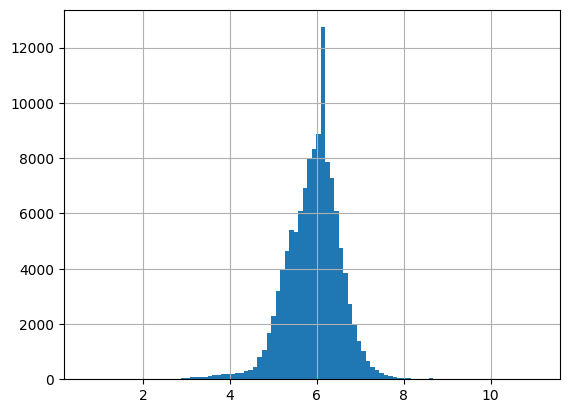

In [17]:
display(train['Y1'].hist(bins = 100))
display(train['Y2'].hist(bins = 100))

## CatBoost

In [16]:
cat_y1 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y1.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    cat_pred = cat_y1.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4683487	test: 0.4643699	best: 0.4643699 (0)	total: 209ms	remaining: 3m 28s
50:	learn: 0.2604469	test: 0.2581759	best: 0.2581759 (50)	total: 3.55s	remaining: 1m 5s
100:	learn: 0.2201515	test: 0.2185352	best: 0.2185352 (100)	total: 6.85s	remaining: 1m
150:	learn: 0.2084152	test: 0.2067285	best: 0.2067285 (150)	total: 10.2s	remaining: 57.4s
200:	learn: 0.2031952	test: 0.2015605	best: 0.2015605 (200)	total: 13.4s	remaining: 53.3s
250:	learn: 0.2002919	test: 0.1986695	best: 0.1986695 (250)	total: 16.7s	remaining: 49.9s
300:	learn: 0.1981867	test: 0.1966666	best: 0.1966666 (300)	total: 20.1s	remaining: 46.8s
350:	learn: 0.1965853	test: 0.1951179	best: 0.1951179 (350)	total: 23.4s	remaining: 43.2s
400:	learn: 0.1951686	test: 0.1938103	best: 0.1938103 (400)	total: 26.4s	remaining: 39.4s
450:	learn: 0.1939151	test: 0.1926599	best: 0.1926599 (450)	total: 29.3s	remaining: 35.7s
500:	learn: 0.1928634	test: 0.1917156	best: 0.1917156 (500)	total: 32.4s	remaining: 32.2s
550:	learn: 0.1919

Processing folds:  20%|██        | 1/5 [01:05<04:22, 65.62s/it]

999:	learn: 0.1864894	test: 0.1867366	best: 0.1867366 (999)	total: 1m 5s	remaining: 0us

bestTest = 0.1867366272
bestIteration = 999

0:	learn: 0.4683996	test: 0.4642173	best: 0.4642173 (0)	total: 55.2ms	remaining: 55.2s
50:	learn: 0.2598162	test: 0.2574600	best: 0.2574600 (50)	total: 3s	remaining: 55.9s
100:	learn: 0.2196797	test: 0.2185521	best: 0.2185521 (100)	total: 6.02s	remaining: 53.6s
150:	learn: 0.2080629	test: 0.2073325	best: 0.2073325 (150)	total: 8.93s	remaining: 50.2s
200:	learn: 0.2029100	test: 0.2024967	best: 0.2024967 (200)	total: 12.4s	remaining: 49.3s
250:	learn: 0.2001487	test: 0.1999414	best: 0.1999414 (250)	total: 15.8s	remaining: 47.2s
300:	learn: 0.1980939	test: 0.1981488	best: 0.1981488 (300)	total: 18.9s	remaining: 44s
350:	learn: 0.1963150	test: 0.1965951	best: 0.1965951 (350)	total: 22.1s	remaining: 40.9s
400:	learn: 0.1948838	test: 0.1953974	best: 0.1953974 (400)	total: 25.2s	remaining: 37.6s
450:	learn: 0.1935708	test: 0.1943093	best: 0.1943093 (450)	total:

Processing folds:  40%|████      | 2/5 [02:08<03:12, 64.13s/it]

999:	learn: 0.1859158	test: 0.1884750	best: 0.1884750 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.1884749946
bestIteration = 999

0:	learn: 0.4668163	test: 0.4703638	best: 0.4703638 (0)	total: 78.4ms	remaining: 1m 18s
50:	learn: 0.2589419	test: 0.2625140	best: 0.2625140 (50)	total: 3.24s	remaining: 1m
100:	learn: 0.2189940	test: 0.2223858	best: 0.2223858 (100)	total: 6.35s	remaining: 56.5s
150:	learn: 0.2073651	test: 0.2108691	best: 0.2108691 (150)	total: 9.42s	remaining: 53s
200:	learn: 0.2022432	test: 0.2057276	best: 0.2057276 (200)	total: 13s	remaining: 51.5s
250:	learn: 0.1992089	test: 0.2028673	best: 0.2028673 (250)	total: 16.5s	remaining: 49.3s
300:	learn: 0.1971715	test: 0.2009203	best: 0.2009203 (300)	total: 20.5s	remaining: 47.5s
350:	learn: 0.1956016	test: 0.1994537	best: 0.1994537 (350)	total: 23.9s	remaining: 44.2s
400:	learn: 0.1941315	test: 0.1980406	best: 0.1980406 (400)	total: 27s	remaining: 40.4s
450:	learn: 0.1929003	test: 0.1969863	best: 0.1969863 (450)	total: 30

Processing folds:  60%|██████    | 3/5 [03:12<02:08, 64.18s/it]

999:	learn: 0.1852418	test: 0.1909651	best: 0.1909651 (999)	total: 1m 3s	remaining: 0us

bestTest = 0.1909651493
bestIteration = 999

0:	learn: 0.4667205	test: 0.4707827	best: 0.4707827 (0)	total: 95.7ms	remaining: 1m 35s
50:	learn: 0.2592261	test: 0.2625146	best: 0.2625146 (50)	total: 3.43s	remaining: 1m 3s
100:	learn: 0.2195061	test: 0.2224980	best: 0.2224980 (100)	total: 6.53s	remaining: 58.1s
150:	learn: 0.2073298	test: 0.2106786	best: 0.2106786 (150)	total: 9.53s	remaining: 53.6s
200:	learn: 0.2023336	test: 0.2059296	best: 0.2059296 (200)	total: 12.5s	remaining: 49.6s
250:	learn: 0.1992941	test: 0.2028620	best: 0.2028620 (250)	total: 15.5s	remaining: 46.2s
300:	learn: 0.1972614	test: 0.2009082	best: 0.2009082 (300)	total: 18.5s	remaining: 43s
350:	learn: 0.1955246	test: 0.1992153	best: 0.1992153 (350)	total: 21.5s	remaining: 39.7s
400:	learn: 0.1942324	test: 0.1979956	best: 0.1979956 (400)	total: 24.4s	remaining: 36.4s
450:	learn: 0.1930125	test: 0.1968701	best: 0.1968701 (450)	to

Processing folds:  80%|████████  | 4/5 [04:13<01:02, 62.71s/it]

999:	learn: 0.1854298	test: 0.1904472	best: 0.1904472 (999)	total: 59.9s	remaining: 0us

bestTest = 0.1904471715
bestIteration = 999

0:	learn: 0.4673102	test: 0.4680484	best: 0.4680484 (0)	total: 68.9ms	remaining: 1m 8s
50:	learn: 0.2602574	test: 0.2588389	best: 0.2588389 (50)	total: 3.07s	remaining: 57.1s
100:	learn: 0.2207596	test: 0.2186946	best: 0.2186946 (100)	total: 5.96s	remaining: 53s
150:	learn: 0.2084712	test: 0.2063290	best: 0.2063290 (150)	total: 8.79s	remaining: 49.4s
200:	learn: 0.2034205	test: 0.2014402	best: 0.2014402 (200)	total: 11.6s	remaining: 46.3s
250:	learn: 0.2002790	test: 0.1986206	best: 0.1986206 (250)	total: 14.6s	remaining: 43.4s
300:	learn: 0.1982035	test: 0.1967889	best: 0.1967889 (300)	total: 17.4s	remaining: 40.4s
350:	learn: 0.1965776	test: 0.1953869	best: 0.1953869 (350)	total: 20.2s	remaining: 37.4s
400:	learn: 0.1951808	test: 0.1942235	best: 0.1942235 (400)	total: 23.2s	remaining: 34.6s
450:	learn: 0.1939656	test: 0.1931757	best: 0.1931757 (450)	tot

Processing folds: 100%|██████████| 5/5 [05:11<00:00, 62.38s/it]

999:	learn: 0.1863010	test: 0.1874334	best: 0.1874334 (999)	total: 58s	remaining: 0us

bestTest = 0.1874334468
bestIteration = 999

Validation : MAE scores for each fold: [0.1867376259106576, 0.18849559904454594, 0.19097547850215166, 0.19045299065799046, 0.18742821192936301]
Validation : MAE: 0.18881798120894172


In [17]:
cat_y2 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y2.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    cat_pred = cat_y2.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5261054	test: 0.5227285	best: 0.5227285 (0)	total: 70.9ms	remaining: 1m 10s
50:	learn: 0.2104587	test: 0.2091360	best: 0.2091360 (50)	total: 3.21s	remaining: 59.8s
100:	learn: 0.1395188	test: 0.1391983	best: 0.1391983 (100)	total: 6.15s	remaining: 54.7s
150:	learn: 0.1180057	test: 0.1172963	best: 0.1172963 (150)	total: 9.02s	remaining: 50.7s
200:	learn: 0.1104163	test: 0.1093704	best: 0.1093704 (200)	total: 11.9s	remaining: 47.1s
250:	learn: 0.1063611	test: 0.1052160	best: 0.1052160 (250)	total: 14.6s	remaining: 43.6s
300:	learn: 0.1040379	test: 0.1028553	best: 0.1028553 (300)	total: 17.5s	remaining: 40.6s
350:	learn: 0.1022793	test: 0.1011431	best: 0.1011431 (350)	total: 20.7s	remaining: 38.3s
400:	learn: 0.1009906	test: 0.0998977	best: 0.0998977 (400)	total: 23.6s	remaining: 35.3s
450:	learn: 0.0998268	test: 0.0987876	best: 0.0987876 (450)	total: 26.5s	remaining: 32.3s
500:	learn: 0.0987525	test: 0.0977936	best: 0.0977936 (500)	total: 29.5s	remaining: 29.3s
550:	learn: 0.

Processing folds:  20%|██        | 1/5 [00:59<03:58, 59.69s/it]

999:	learn: 0.0935976	test: 0.0932986	best: 0.0932986 (999)	total: 59.2s	remaining: 0us

bestTest = 0.09329856453
bestIteration = 999

0:	learn: 0.5252754	test: 0.5256301	best: 0.5256301 (0)	total: 81.6ms	remaining: 1m 21s
50:	learn: 0.2118122	test: 0.2106049	best: 0.2106049 (50)	total: 3.15s	remaining: 58.6s
100:	learn: 0.1403820	test: 0.1379017	best: 0.1379017 (100)	total: 6.16s	remaining: 54.8s
150:	learn: 0.1189393	test: 0.1161798	best: 0.1161798 (150)	total: 9.04s	remaining: 50.9s
200:	learn: 0.1108036	test: 0.1080420	best: 0.1080420 (200)	total: 12s	remaining: 47.8s
250:	learn: 0.1066998	test: 0.1039567	best: 0.1039567 (250)	total: 15s	remaining: 44.8s
300:	learn: 0.1041030	test: 0.1014679	best: 0.1014679 (300)	total: 17.9s	remaining: 41.6s
350:	learn: 0.1023516	test: 0.0998090	best: 0.0998090 (350)	total: 20.9s	remaining: 38.6s
400:	learn: 0.1010581	test: 0.0985897	best: 0.0985897 (400)	total: 23.8s	remaining: 35.6s
450:	learn: 0.0999013	test: 0.0974956	best: 0.0974956 (450)	tot

Processing folds:  40%|████      | 2/5 [01:58<02:57, 59.33s/it]

999:	learn: 0.0938955	test: 0.0919373	best: 0.0919373 (999)	total: 58.6s	remaining: 0us

bestTest = 0.09193728251
bestIteration = 999

0:	learn: 0.5253151	test: 0.5253812	best: 0.5253812 (0)	total: 70.8ms	remaining: 1m 10s
50:	learn: 0.2106070	test: 0.2119169	best: 0.2119169 (50)	total: 3.14s	remaining: 58.5s
100:	learn: 0.1391614	test: 0.1411529	best: 0.1411529 (100)	total: 6.08s	remaining: 54.2s
150:	learn: 0.1173267	test: 0.1197592	best: 0.1197592 (150)	total: 8.91s	remaining: 50.1s
200:	learn: 0.1092188	test: 0.1118213	best: 0.1118213 (200)	total: 11.8s	remaining: 46.9s
250:	learn: 0.1053787	test: 0.1080626	best: 0.1080626 (250)	total: 14.7s	remaining: 43.7s
300:	learn: 0.1029182	test: 0.1056164	best: 0.1056164 (300)	total: 17.6s	remaining: 40.8s
350:	learn: 0.1012789	test: 0.1040473	best: 0.1040473 (350)	total: 20.5s	remaining: 37.8s
400:	learn: 0.0999429	test: 0.1027868	best: 0.1027868 (400)	total: 23.3s	remaining: 34.8s
450:	learn: 0.0988151	test: 0.1017683	best: 0.1017683 (450)

Processing folds:  60%|██████    | 3/5 [02:57<01:57, 58.91s/it]

999:	learn: 0.0927600	test: 0.0963268	best: 0.0963268 (999)	total: 58s	remaining: 0us

bestTest = 0.09632680165
bestIteration = 999

0:	learn: 0.5255034	test: 0.5246103	best: 0.5246103 (0)	total: 62.3ms	remaining: 1m 2s
50:	learn: 0.2092156	test: 0.2096469	best: 0.2096469 (50)	total: 3.07s	remaining: 57.1s
100:	learn: 0.1385038	test: 0.1400341	best: 0.1400341 (100)	total: 6.04s	remaining: 53.8s
150:	learn: 0.1171366	test: 0.1191033	best: 0.1191033 (150)	total: 8.91s	remaining: 50.1s
200:	learn: 0.1092607	test: 0.1112987	best: 0.1112987 (200)	total: 11.8s	remaining: 46.7s
250:	learn: 0.1056492	test: 0.1076799	best: 0.1076799 (250)	total: 14.6s	remaining: 43.5s
300:	learn: 0.1032154	test: 0.1052152	best: 0.1052152 (300)	total: 17.5s	remaining: 40.7s
350:	learn: 0.1015041	test: 0.1034557	best: 0.1034557 (350)	total: 20.5s	remaining: 37.9s
400:	learn: 0.1002175	test: 0.1021789	best: 0.1021789 (400)	total: 23.4s	remaining: 34.9s
450:	learn: 0.0991301	test: 0.1010806	best: 0.1010806 (450)	to

Processing folds:  80%|████████  | 4/5 [03:55<00:58, 58.87s/it]

999:	learn: 0.0929731	test: 0.0953641	best: 0.0953641 (999)	total: 58.3s	remaining: 0us

bestTest = 0.09536409994
bestIteration = 999

0:	learn: 0.5245922	test: 0.5284811	best: 0.5284811 (0)	total: 67.9ms	remaining: 1m 7s
50:	learn: 0.2108489	test: 0.2120736	best: 0.2120736 (50)	total: 3.07s	remaining: 57.1s
100:	learn: 0.1398715	test: 0.1399205	best: 0.1399205 (100)	total: 6.01s	remaining: 53.5s
150:	learn: 0.1178044	test: 0.1178836	best: 0.1178836 (150)	total: 8.94s	remaining: 50.3s
200:	learn: 0.1095826	test: 0.1100659	best: 0.1100659 (200)	total: 11.8s	remaining: 46.8s
250:	learn: 0.1056030	test: 0.1063704	best: 0.1063704 (250)	total: 14.6s	remaining: 43.7s
300:	learn: 0.1030920	test: 0.1039743	best: 0.1039743 (300)	total: 17.5s	remaining: 40.6s
350:	learn: 0.1013101	test: 0.1022720	best: 0.1022720 (350)	total: 20.5s	remaining: 37.9s
400:	learn: 0.0999798	test: 0.1010522	best: 0.1010522 (400)	total: 23.4s	remaining: 35s
450:	learn: 0.0988539	test: 0.1000160	best: 0.1000160 (450)	to

Processing folds: 100%|██████████| 5/5 [04:56<00:00, 59.24s/it]

999:	learn: 0.0929426	test: 0.0945694	best: 0.0945694 (999)	total: 59.7s	remaining: 0us

bestTest = 0.0945693985
bestIteration = 999

Validation : MAE scores for each fold: [0.09329956362722393, 0.09199032025104963, 0.09635979714276041, 0.09538790263194401, 0.09457049573431983]
Validation : MAE: 0.09432161587745955


## MLJAR

In [ ]:
!pip install mljar-supervised

In [ ]:
categorical_features = ['X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [ ]:
from supervised.automl import AutoML

train_x1 = train.drop(['Y1', 'Y2'], axis=1)
train_x2 = train.drop(['Y1', 'Y2'], axis=1)

train_y1 = train['Y1']
train_y2 = train['Y2']


Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 112
}

In [ ]:
automl_y1 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit = 1800 * 2 * 5)
automl_y1.fit(train_x1, train_y1)

In [ ]:
automl_y2 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit=1800 * 2 * 5)
automl_y2.fit(train_x2, train_y2)

In [ ]:
pred_y1 = automl_y1.predict_all(test)
pred_y2 = automl_y2.predict_all(test)

In [ ]:
final_predictions = (np.expm1(pred_y1)) + (np.expm1(pred_y2))

## 제출

In [18]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [28]:
final_predictions = np.expm1(final_predictions_y1) + np.expm1(final_predictions_y2)
final_predictions = np.round(final_predictions / 10) * 10

submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,2860.0
1,1,1680.0
2,2,3190.0
3,3,4080.0
4,4,1360.0
...,...,...
40566,40566,830.0
40567,40567,1320.0
40568,40568,2160.0
40569,40569,1130.0


In [29]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1128-5.csv', index=False)

In [30]:
display(train)
display(test)

,X2,X3,X4,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,X2/X3,SPT,SPTCC
0,56.3,67.5,22.5,4,97,PL973,6.148468,7.715124,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069,313.6,0.834074,13.937778,55.751111
1,115.0,67.0,13.0,2,27,PL271,6.965080,7.059618,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,1.716418,24.123077,48.246154
2,59.2,44.6,18.0,1,14,PL141,5.602119,6.998510,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690,313.6,1.327354,17.422222,17.422222
3,52.1,97.4,15.0,17,24,PL242,5.971262,7.865188,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657,235.0,0.534908,15.666667,266.333333
4,42.9,58.7,14.5,4,23,PL233,5.451038,7.355641,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.730835,16.206897,64.827586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,98.4,89.5,10.0,8,21,PS213,6.810142,7.112327,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671,235.0,1.099441,23.500000,188.000000
121750,48.0,51.0,23.0,1,23,PL231,5.170484,7.340187,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385,352.8,0.941176,15.339130,15.339130
121751,42.5,30.2,34.0,5,27,PL272,5.932245,7.308543,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574,352.8,1.407285,10.376471,51.882353
121752,22.1,15.3,36.0,8,97,PL973,4.454347,6.584791,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069,352.8,1.444444,9.800000,78.400000


,X2,X3,X4,X6,X7,X8,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,X2/X3,SPT,SPTCC
0,80.6,104.8,11.0,29,23,PL234,951.562925,2206.966183,406.549153,3019.517627,398.878939,2964.716418,235.0,0.769084,21.363636,619.545455
1,141.8,34.2,17.5,2,91,PL911,951.562925,2206.966183,568.997560,2002.743398,568.997560,2002.743398,235.0,4.146199,13.428571,26.857143
2,77.2,103.3,17.0,10,97,PL973,951.562925,2206.966183,424.774954,2635.545978,414.072878,2632.468069,235.0,0.747338,13.823529,138.235294
3,95.5,131.0,18.0,2,23,PL234,951.562925,2206.966183,406.549153,3019.517627,398.878939,2964.716418,235.0,0.729008,13.055556,26.111111
4,91.7,36.1,19.0,1,27,PL271,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,2.540166,16.505263,16.505263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40566,27.0,13.0,19.0,21,25,PL252,588.517493,2255.398250,4893.006711,2283.908064,19516.920543,1108.062500,313.6,2.076923,16.505263,346.610526
40567,44.2,41.3,19.5,2,14,PL142,588.517493,2255.398250,304.917220,1160.583795,310.408034,1158.719345,313.6,1.070218,16.082051,32.164103
40568,54.9,70.5,15.0,10,23,PL233,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.778723,15.666667,156.666667
40569,44.1,43.2,16.0,1,27,PL272,951.562925,2206.966183,512.662090,1440.456061,585.325622,1431.167574,235.0,1.020833,14.687500,14.687500
